In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%pylab inline
pd.options.display.max_columns=100
pd.options.display.max_rows=15
#importing Dataset

os.chdir("D:\\analytixlabs\\Complete_datasets")
print os.getcwd() 
Telecom=pd.read_csv("Proactive Attrition Management-Logistic Regression Case Study.csv")


Populating the interactive namespace from numpy and matplotlib
D:\analytixlabs\Complete_datasets


In [2]:
Val_Telecom=Telecom.loc[Telecom.CHURNDEP.isnull()]
TT_Telecom=Telecom.loc[Telecom.CHURNDEP.isin([0,1])]
print Val_Telecom.shape
print TT_Telecom.shape

def missing(x):
    return sum(x.isnull())

#print "Missing values per column:"
#TT_Telecom.loc[ : ,TT_Telecom.apply(missing, axis=0)!=0]

(31047, 78)
(40000, 78)


In [3]:
TT_Telecom.drop(labels=['CHURN','RETCALL','RETCALLS','RETACCPT'],inplace=True,axis=1)

C:\Users\Lenovo\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [13]:
#removing these 2 columns will give us the base model with any NAs['CALIBRAT' ,'CALLFWDV' ,'CALLWAIT',]
from warnings import WarningMessage,filterwarnings


TT_Telecom.drop(labels=['CHURN','CALIBRAT' ,'CALLFWDV' ,'CALLWAIT','CUSTOMER','RETCALL','RETCALLS','RETACCPT','MODELS','MOUREC',
                        'BLCKVCE','OWNRENT','OVERAGE','UNIQSUBS','AGE2','PEAKVCE','OPEAKVCE','CHILDREN',
                         'CREDITGY', 'CREDITZ',  'CREDITB','REFURB',
                        'TRUCK','RV','MARRYUN','MAILORD','PCOWN','NEWCELLN','MCYCLE','REVENUE','MAILFLAG',
                       'OCCSELF','OCCPROF','OCCRET','OCCSELF','OCCHMKR','OCCCLER','CREDITCD','NEWCELLN','SETPRCM'],inplace=True,axis=1)
TT_Telecom.dropna(subset=['AGE1','CHANGEM'],inplace=True)

#CSA cant be identified so we we will keep them as missing
TT_Telecom.CSA.fillna('Missing',inplace=True)

C:\Users\Lenovo\Anaconda2\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Lenovo\Anaconda2\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [4]:
X=TT_Telecom.ix[:,TT_Telecom.columns != 'CHURNDEP']
y=TT_Telecom.CHURNDEP
#X_test=Val_Telecom.ix[:,:-1]
#y_test=Val_Telecom.CHURNDEP

from sklearn.cross_validation import train_test_split
X_train,X_test,y_train, y_test=train_test_split(X,y,test_size=0.20,random_state=0)

print X_train.shape
print X_test.shape
print y_train.shape
print y_test.shape

(32000, 73)
(8000, 73)
(32000L,)
(8000L,)


In [15]:
from sklearn.preprocessing import LabelEncoder
lbl_enc=LabelEncoder()
lbl_enc.fit(X_train['CSA'])
X_train.CSA=lbl_enc.transform(X_train['CSA'])

lbl_enc.fit(X_test['CSA'])
X_test.CSA=lbl_enc.transform(X_test['CSA'])

In [16]:
names=X_train.columns.tolist()

In [19]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
X_train = sc.fit_transform(X_train)
X_test= sc.fit_transform(X_test)

In [5]:
def mosthighlycorrelated(mydataframe, numtoreport):
    # find the correlations
    cormatrix = mydataframe.corr()
    # set the correlations on the diagonal or lower triangle to zero,
    # so they will not be reported as the highest ones:
    cormatrix *= np.tri(*cormatrix.values.shape, k=-1).T
    # find the top n correlations
    cormatrix = cormatrix.stack()
    cormatrix = cormatrix.reindex(cormatrix.abs().sort_values(ascending=False).index).reset_index()
    # assign human-friendly names
    cormatrix.columns = ["FirstVariable", "SecondVariable", "Correlation"]
    return cormatrix.head(numtoreport)

In [6]:
mosthighlycorrelated(X_train,10)

,FirstVariable,SecondVariable,Correlation
0,MAILORD,MAILRES,0.968318
1,PHONES,MODELS,0.887336
2,MOU,MOUREC,0.832264
3,CREDITCD,INCMISS,-0.825071
4,OWNRENT,CREDITCD,-0.806862
5,BLCKVCE,DROPBLK,0.806656
6,OWNRENT,INCMISS,0.805790
7,INCMISS,INCOME,-0.802047
8,UNIQSUBS,ACTVSUBS,0.792135
9,REVENUE,OVERAGE,0.784410


Optimal number of features : 20


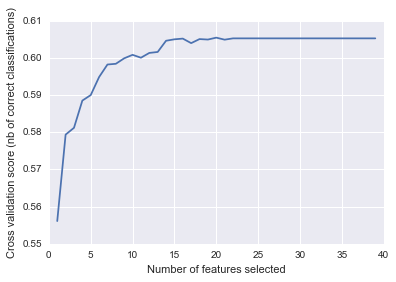

In [20]:
from sklearn.cross_validation import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# Create the RFE object and compute a cross-validated score.
adb = AdaBoostClassifier()
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=adb, step=1, cv=StratifiedKFold(y_train, 2),
              scoring='accuracy')
rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [27]:
print sorted(zip(map(lambda x: round(x, 4), rfecv.ranking_), names),reverse=False)
#print X_train.head(1)
rfecv.ranking_
fe=sorted(zip(map(lambda x: round(x, 4), rfecv.ranking_), names),reverse=False)
print [y for (x,y) in fe][:20]

[(1.0, 'ACTVSUBS'), (1.0, 'AGE1'), (1.0, 'CHANGEM'), (1.0, 'CHANGER'), (1.0, 'CREDITC'), (1.0, 'CREDITDE'), (1.0, 'CSA'), (1.0, 'CUSTCARE'), (1.0, 'DROPBLK'), (1.0, 'DROPVCE'), (1.0, 'EQPDAYS'), (1.0, 'INCALLS'), (1.0, 'MAILRES'), (1.0, 'MONTHS'), (1.0, 'MOU'), (1.0, 'PHONES'), (1.0, 'RECCHRGE'), (1.0, 'ROAM'), (1.0, 'SETPRC'), (1.0, 'WEBCAP'), (2.0, 'UNANSVCE'), (3.0, 'PRIZMRUR'), (4.0, 'OUTCALLS'), (5.0, 'INCOME'), (6.0, 'OCCSTUD'), (7.0, 'MARRYNO'), (8.0, 'DIRECTAS'), (9.0, 'NEWCELLY'), (10.0, 'PRIZMUB'), (11.0, 'REFER'), (12.0, 'INCMISS'), (13.0, 'MARRYYES'), (14.0, 'CREDITAD'), (15.0, 'CREDITAA'), (16.0, 'PRIZMTWN'), (17.0, 'THREEWAY'), (18.0, 'TRAVEL'), (19.0, 'OCCCRFT'), (20.0, 'CREDITA')]
['ACTVSUBS', 'AGE1', 'CHANGEM', 'CHANGER', 'CREDITC', 'CREDITDE', 'CSA', 'CUSTCARE', 'DROPBLK', 'DROPVCE', 'EQPDAYS', 'INCALLS', 'MAILRES', 'MONTHS', 'MOU', 'PHONES', 'RECCHRGE', 'ROAM', 'SETPRC', 'WEBCAP']


### applyin PCA

[ 12.82  20.33  25.46  29.77  33.74  36.97  40.09  43.01  45.77  48.42
  51.03  53.61  56.14  58.66  61.15  63.61  66.02  68.42  70.71  72.97
  75.19  77.38  79.41  81.33  83.18  84.85  86.49  88.07  89.5   90.9 ]


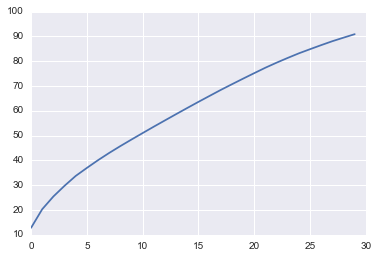

In [21]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

#Scaling the values
X = scale(X_train)
Xt=scale(X_test)


pca = PCA(n_components=30)
pca.fit(X)

#The amount of variance that each PC explains
var= pca.explained_variance_ratio_

#Cumulative Variance explains
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

print var1

plt.plot(var1)



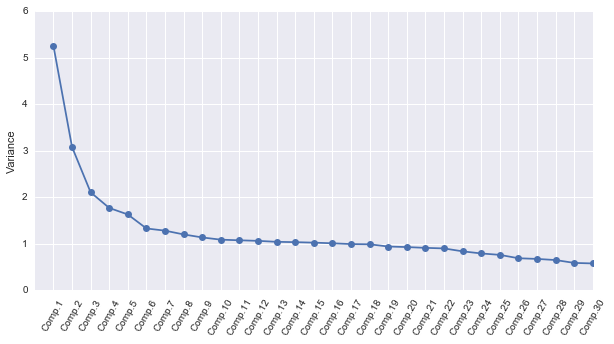

In [22]:
def screeplot(pca, standardised_values):
    y = np.std(pca.transform(standardised_values), axis=0)**2
    x = np.arange(len(y)) + 1
    plt.figure(figsize=(10,5))
    plt.plot(x, y, "o-")
    plt.xticks(x, ["Comp."+str(i) for i in x], rotation=60)
    plt.ylabel("Variance")
    plt.show()
    

screeplot(pca,X)

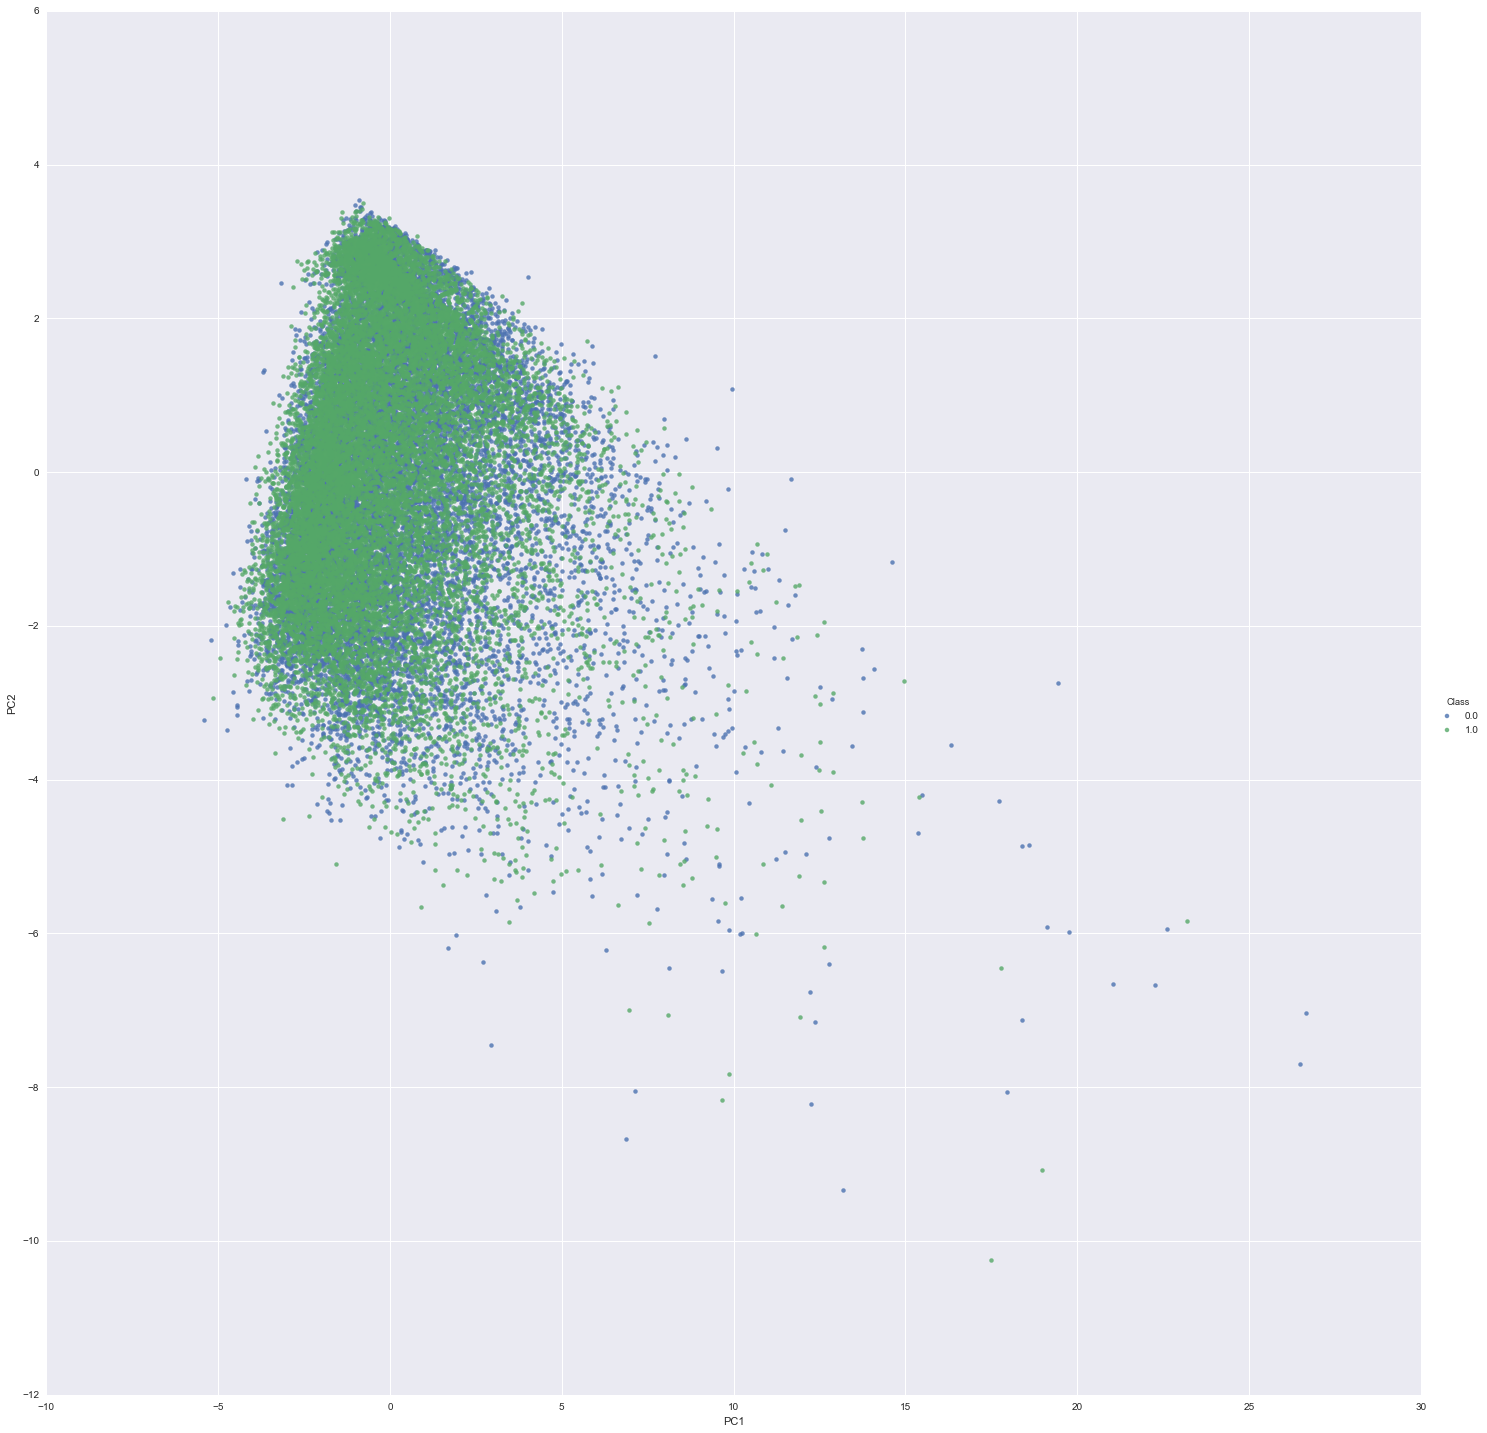

In [25]:
def pca_scatter(pca, standardised_values, classifs):
    foo = pca.transform(standardised_values)
    bar = pd.DataFrame(zip(foo[:, 0], foo[:, 1], classifs), columns=["PC1", "PC2", "Class"])
    sns.lmplot("PC1", "PC2", bar, hue="Class",size=20, fit_reg=False)

pca_scatter(pca, X, y_train)

In [26]:
#Looking at above plot I'm taking 30 variables
pca = PCA(n_components=24)
pca.fit(X)
X1=pca.fit_transform(X)
Xtest=pca.fit_transform(Xt)

print Xtest

[[-1.33538403 -2.8117437  -0.99213878 ..., -0.33100693  0.19140342
  -0.56370643]
 [-1.14895263 -1.69458287  2.35482721 ..., -0.26168517  0.00770995
   0.08415222]
 [ 4.98901885  0.64216992 -0.63865053 ..., -0.90548712 -0.26893158
  -0.06293509]
 ..., 
 [ 0.31016862  1.84708334 -2.54263385 ...,  0.29980584  0.06692923
   0.43388697]
 [-1.67948546 -2.43935755  0.85071824 ..., -0.16313544  0.28572355
  -1.9980301 ]
 [ 1.3507858  -0.54542548 -0.59480083 ...,  0.61357619  0.67249096
  -0.16828344]]


In [ ]:
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# Create the RFE object and compute a cross-validated score.
adb = AdaBoostClassifier()
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=adb, step=1, cv=StratifiedKFold(y_train, 2),
              scoring='accuracy')
rfecv.fit(X, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

## Final model

In [27]:
from matplotlib.colors import ListedColormap
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Decision Tree",
         "Random Forest", "AdaBoost", "Naive Bayes", "Linear Discriminant Analysis",
         "Quadratic Discriminant Analysis"]
classifiers = [
    KNeighborsClassifier(2),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=600, max_features=1),
    AdaBoostClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]


In [28]:
# iterate over classifiers
for name, clf in zip(names, classifiers):
    clf.fit(X1, y_train)
    score = clf.score(Xtest, y_test)
    print '*'*100
    print '*'*100
    print "Classifier is " + str(name)
    
    print "SCORE" + str(score)
    

****************************************************************************************************
****************************************************************************************************
Classifier is Nearest Neighbors
SCORE0.507767364232
****************************************************************************************************
****************************************************************************************************
Classifier is Linear SVM
SCORE0.548465785082
****************************************************************************************************
****************************************************************************************************
Classifier is RBF SVM
SCORE0.500192579278
****************************************************************************************************
****************************************************************************************************
Classifier is Decision Tree
SCORE0.539221979715
*****